In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from pandas_datareader.data import DataReader
import statsmodels.tsa.stattools as sts
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import math
import cvxopt as opt
from cvxopt import blas, solvers
from yahoofinancials import YahooFinancials
import prettytable
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.io as pio
from scipy.stats.mstats import gmean
%pylab inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
import glob 
warnings.simplefilter(action='ignore')
pio.renderers.default = 'iframe'
import ipywidgets as widgets
pyo.init_notebook_mode(connected = True)
from ipywidgets import interactive, HBox, VBox, widgets, interact
from ipywidgets import FloatSlider

Populating the interactive namespace from numpy and matplotlib


## Scope of the project:-

#### We are trying to analyse how a portfolio comprising of three asset classes(equity, fed bonds and gold) perform when compared with and without various market regime, we are considering two market regimes(0 =  expansion and 1 = recession). We use GDP data to determine which regime the current market is(though idea is to include inflation and enemployemt data as well while calculating the regime) 

## Step - One - First Load Monthly Asset class Data(S&P 500(Yahoo Finance), 13 Week Treasury Bill(Yahoo Finance), Gold Price(Bloomberg Terminal))

In [2]:
equity = yf.download('^GSPC',interval = '1mo',period='max')
equity['equity_ret'] = equity['Adj Close'].pct_change()
equity.rename(columns={'Adj Close':'equity_price'},inplace=True)
equity.index = pd.to_datetime(equity.index)
equity = equity['1960-01-01':'2020-12-01'] # We just deal with data in these date range

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,equity_price,Volume,equity_ret
Date,,,,,,,
1960-01-01,59.910000,60.389999,55.610001,55.610001,55.610001,63920000,-0.071464
1960-02-01,55.959999,56.820000,54.730000,56.119999,56.119999,60500000,0.009171
1960-03-01,56.009998,56.009998,53.470001,55.340000,55.340000,65710000,-0.013899
1960-04-01,55.430000,56.590000,54.369999,54.369999,54.369999,57300000,-0.017528
1960-05-01,54.130001,55.830002,54.130001,55.830002,55.830002,68790000,0.026853
...,...,...,...,...,...,...,...
2020-08-01,3288.260010,3514.770020,3284.530029,3500.310059,3500.310059,84402300000,0.070065
2020-09-01,3507.439941,3588.110107,3209.449951,3363.000000,3363.000000,92084120000,-0.039228
2020-10-01,3385.870117,3549.850098,3233.939941,3269.959961,3269.959961,89737600000,-0.027666


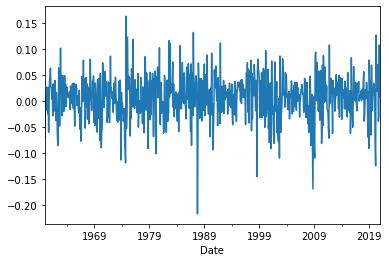

In [3]:
equity['equity_ret'].plot()
equity

### We Calculate the Bond return and bond price from  the bond Yield

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,bond_yield,Volume,days,int_ret,bond_price,price_ret,bond_ret
Date,,,,,,,,,,,
1960-01-01,4.520,4.680,3.920,3.990,3.990,0,NaN,NaN,0.990162,NaN,NaN
1960-02-01,4.000,4.190,3.550,4.190,4.190,0,31.0,0.003559,0.989668,-0.000493,0.003096
1960-03-01,4.090,4.090,2.680,3.020,3.020,0,29.0,0.002399,0.992553,0.002885,0.005340
1960-04-01,2.840,3.600,2.720,3.040,3.040,0,31.0,0.002582,0.992504,-0.000049,0.002552
1960-05-01,3.030,3.670,3.030,3.120,3.120,0,30.0,0.002564,0.992307,-0.000197,0.002385
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,0.083,0.103,0.075,0.095,0.095,0,31.0,0.000081,0.999766,-0.000030,0.000051
2020-09-01,0.100,0.110,0.075,0.085,0.085,0,31.0,0.000072,0.999790,0.000025,0.000097
2020-10-01,0.088,0.100,0.080,0.083,0.083,0,30.0,0.000068,0.999795,0.000005,0.000073


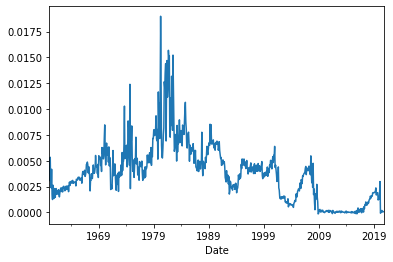

In [4]:
bond = yf.download('^IRX',interval = '1mo',period='max')
bond.reset_index(inplace=True)
bond.rename(columns={'Adj Close':'bond_yield'},inplace=True)

bond['days']= bond['Date']-bond['Date'].shift(1)
bond['days'] = bond['days'].dt.days.astype('float')

bond ['int_ret'] = bond.bond_yield/100/365*bond.days

bond['bond_price'] = 1-(bond.bond_yield/100*90/365)

bond['price_ret'] = bond.bond_price-bond.bond_price.shift(1)
bond['bond_ret'] = (bond.int_ret+bond.price_ret)/bond.bond_price.shift(1)
bond.set_index('Date',inplace=True)
bond = bond['1960-01-01':'2020-12-01'] # We just deal with data in these date range
bond['bond_ret'].plot()
bond

### We now read the Gold Data from the bloomberg terminal(as CSV), data available in yahoo finance does noty gop back beyond Y2K

,Price,gold_ret
Date,,
1960-01-01,35.27,0.004843
1960-02-01,35.27,0.000000
1960-03-01,35.27,0.000000
1960-04-01,35.27,0.000000
1960-05-01,35.27,0.000000
...,...,...
2020-08-01,1967.80,-0.004079
2020-09-01,1885.82,-0.041661
2020-10-01,1878.81,-0.003717


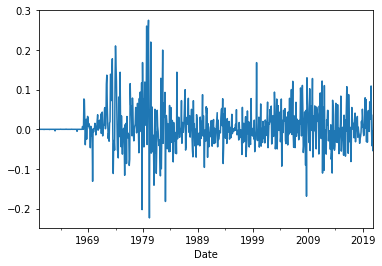

In [5]:
gold = pd.read_csv('gold_data_bloomberg.csv', parse_dates=True)
gold.rename(columns={'Last Price':'Price'},inplace=True)

gold['Date']= pd.to_datetime(gold['Date'])
Gold_date = []
for x in gold.to_dict('records'):
    gold_date = dt.date(x['Date'])
    Gold_date += [gold_date]
gold_dates = []
for x in Gold_date:
    y = x.strftime("%Y-%m-01")
    gold_dates += [y]
gold['Date'] = pd.to_datetime(gold_dates)
gold['gold_ret'] = gold.Price.pct_change()
gold.set_index('Date',inplace=True)
gold = gold['1960-01-01':'2020-12-01']
gold['gold_ret'].plot()
gold

### We also Read Forex Data, but we dont have data beyond 1971, so here we would only work with three asset class

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,forex_price,Volume,forex_ret
Date,,,,,,,
1971-01-01,120.529999,120.550003,120.239998,120.239998,120.239998,0,NaN
1971-02-01,120.260002,120.290001,120.120003,120.260002,120.260002,0,0.000166
1971-03-01,120.250000,120.250000,120.129997,120.169998,120.169998,0,-0.000748
1971-04-01,120.180000,120.309998,120.160004,120.190002,120.190002,0,0.000166
1971-05-01,120.169998,120.169998,118.910004,119.430000,119.430000,0,-0.006323
...,...,...,...,...,...,...,...
2020-09-01,92.180000,94.739998,91.750000,93.889999,93.889999,0,0.018993
2020-10-01,93.800003,94.099998,92.470001,94.040001,94.040001,0,0.001598
2020-11-01,93.889999,94.300003,91.510002,91.870003,91.870003,0,-0.023075


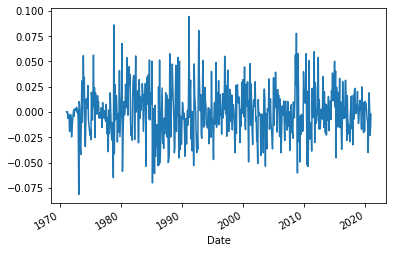

In [6]:
forex_df = yf.download('DX-Y.NYB',interval = '1mo',period='max')
forex_df['forex_ret'] = forex_df['Adj Close'].pct_change()
forex_df.rename(columns={'Adj Close':'forex_price'},inplace=True)
forex_df.index = pd.to_datetime(forex_df.index)
forex_df['forex_ret'].plot()
forex_df

In [7]:
assets_daily_ret_all = pd.concat([equity, bond], axis=1, join='inner')[['equity_ret','bond_ret']]
assets_daily_ret_all['gold_ret'] = gold['gold_ret'].values
assets_daily_ret_all

,equity_ret,bond_ret,gold_ret
Date,,,
1960-01-01,-0.071464,NaN,0.004843
1960-02-01,0.009171,0.003096,0.000000
1960-03-01,-0.013899,0.005340,0.000000
1960-04-01,-0.017528,0.002552,0.000000
1960-05-01,0.026853,0.002385,0.000000
...,...,...,...
2020-08-01,0.070065,0.000051,-0.004079
2020-09-01,-0.039228,0.000097,-0.041661
2020-10-01,-0.027666,0.000073,-0.003717


#### Fist get the price table for all asset for whole range.

In [8]:
assets_daily_price_all = pd.concat([equity, bond], axis=1, join='inner')
assets_daily_price_all = assets_daily_price_all[['equity_price','bond_price']]
assets_daily_price_all['gold_price'] = gold['Price'].values
assets_daily_price_all

,equity_price,bond_price,gold_price
Date,,,
1960-01-01,55.610001,0.990162,35.27
1960-02-01,56.119999,0.989668,35.27
1960-03-01,55.340000,0.992553,35.27
1960-04-01,54.369999,0.992504,35.27
1960-05-01,55.830002,0.992307,35.27
...,...,...,...
2020-08-01,3500.310059,0.999766,1967.80
2020-09-01,3363.000000,0.999790,1885.82
2020-10-01,3269.959961,0.999795,1878.81


#### Then calculate the quarterly return

,equity_qtr_ret,bond_qtr_ret,gold_qtr_ret
Date,,,
1960-03-31,NaN,NaN,NaN
1960-06-30,0.028551,0.002062,0.000000
1960-09-30,-0.059733,-0.000273,0.000000
1960-12-31,0.085762,0.000248,0.000000
1961-03-31,0.119601,-0.000545,-0.000567
...,...,...,...
2019-12-31,0.085342,0.000656,0.030411
2020-03-31,-0.200011,0.003651,0.039485
2020-06-30,0.199529,-0.000259,0.129205


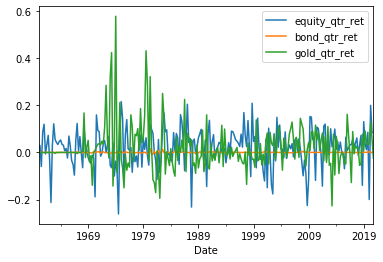

In [9]:
assets_qtr_ret_all = assets_daily_price_all.resample('Q').ffill().pct_change()
assets_qtr_ret_all.rename(columns={'equity_price':'equity_qtr_ret',
                                   'bond_price':'bond_qtr_ret',
                          'gold_price':'gold_qtr_ret'}, inplace=True)
assets_qtr_ret_all.plot()
assets_qtr_ret_all

## Step - Two - Load USA GDP(Percent Change from Preceding Period, Seasonally Adjusted Annual Rate) Data from fred website Also we download the Recession(actual) data from fred website.

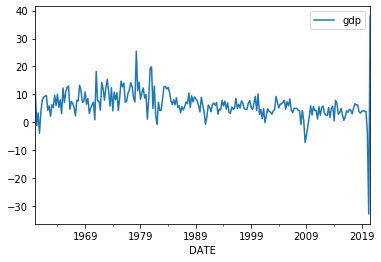

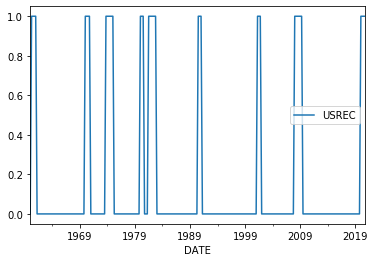

In [10]:
usrec = DataReader('USREC', 'fred', start=dt(1959, 12, 31))
usrec = usrec.resample('Q', convention = 'end').max()

gdp = DataReader('A191RP1Q027SBEA', 'fred', start=dt(1959, 12, 31))
gdp = gdp.resample('Q', convention = 'end').max()
# gdp.reset_index(inplace=True)
gdp.rename(columns={'A191RP1Q027SBEA':'gdp'},inplace=True)
gdp.plot()
usrec.plot()

In [11]:
gdp

,gdp
DATE,
1960-03-31,11.1
1960-06-30,-1.2
1960-09-30,3.4
1960-12-31,-3.9
1961-03-31,3.6
...,...
2019-09-30,4.0
2019-12-31,3.9
2020-03-31,-3.4


In [12]:
usrec

,USREC
DATE,
1960-03-31,0
1960-06-30,1
1960-09-30,1
1960-12-31,1
1961-03-31,1
...,...
2019-12-31,0
2020-03-31,1
2020-06-30,1


## Step - Three - Idea here is to first form a set of Two types of Data


### a) Get four lagged values of GDP and two lagged value of every asset class to perform a gradient booster method to predict a supervised learned binary value of a recession or an expansion

### To aviod any present data from predicting a present value, we use rolling method of prediction, that is data from training data(rolling 12 months) set is used to predict for the first quarter of the test data set, then we increase training data by adding the actual data from test data set for that quarter to keep on rolling 

### b) Use GDP data and univariate Markov 

In [13]:

assets_qtr_ret_all_temp = assets_qtr_ret_all.copy()

assets_qtr_ret_all_temp['equity_qrt_ret_lag_2'] = assets_qtr_ret_all_temp['equity_qtr_ret'].shift(2)
assets_qtr_ret_all_temp['bond_qrt_ret_lag_2'] = assets_qtr_ret_all_temp['bond_qtr_ret'].shift(2)
assets_qtr_ret_all_temp['gold_qrt_ret_lag_2'] = assets_qtr_ret_all_temp['gold_qtr_ret'].shift(2)

In [14]:
assets_qtr_ret_all_temp = assets_qtr_ret_all_temp[assets_qtr_ret_all_temp.index<='2020-09-30']
data = pd.DataFrame()
data['Date'] = gdp.index[gdp.index>='1960-03-31'].values
data['gdp_no_lag'] = gdp['gdp'].values

data['gdp_lag_1'] = data['gdp_no_lag'].shift(1)
data['gdp_lag_2'] = data['gdp_no_lag'].shift(2)
data['gdp_lag_3'] = data['gdp_no_lag'].shift(3)
data['gdp_lag_4'] = data['gdp_no_lag'].shift(4)
data['equity_qrt_ret_lag_2'] = assets_qtr_ret_all_temp['equity_qtr_ret'].shift(2).values
data['bond_qrt_ret_lag_2'] = assets_qtr_ret_all_temp['bond_qtr_ret'].shift(2).values
data['gold_qrt_ret_lag_2'] = assets_qtr_ret_all_temp['gold_qtr_ret'].shift(2).values
data.set_index('Date',inplace=True)
data = data[4:] # Need to do this a whole of 1960 would be NAN(as we shift 4 quarters)
data = data.drop(['gdp_no_lag'], axis=1)

In [15]:
train_set = data[data.index<='1979-12-31']
test_set = data[data.index>='1980-03-31']

print(len(train_set), len(test_set))


76 163


In [16]:
test_set

,gdp_lag_1,gdp_lag_2,gdp_lag_3,gdp_lag_4,equity_qrt_ret_lag_2,bond_qrt_ret_lag_2,gold_qrt_ret_lag_2
Date,,,,,,,
1980-03-31,8.7,12.3,10.6,8.3,0.062287,-0.002950,0.431532
1980-06-30,10.0,8.7,12.3,10.6,-0.012623,-0.004855,0.288861
1980-09-30,1.1,10.0,8.7,12.3,-0.054197,-0.005591,-0.034180
1980-12-31,8.7,1.1,10.0,8.7,0.119013,0.016253,0.321537
1981-03-31,19.3,8.7,1.1,10.0,0.098214,-0.008952,0.020275
...,...,...,...,...,...,...,...
2019-09-30,4.1,4.0,3.3,3.8,0.130662,-0.000069,0.007712
2019-12-31,4.0,4.1,4.0,3.3,0.037878,0.000727,0.090662
2020-03-31,3.9,4.0,4.1,4.0,0.011891,0.000657,0.044653


In [17]:
train_set

,gdp_lag_1,gdp_lag_2,gdp_lag_3,gdp_lag_4,equity_qrt_ret_lag_2,bond_qrt_ret_lag_2,gold_qrt_ret_lag_2
Date,,,,,,,
1961-03-31,-3.9,3.4,-1.2,11.1,-0.059733,-0.000273,0.000000
1961-06-30,3.6,-3.9,3.4,-1.2,0.085762,0.000248,0.000000
1961-09-30,8.0,3.6,-3.9,3.4,0.119601,-0.000545,-0.000567
1961-12-31,9.0,8.0,3.6,-3.9,-0.006456,0.000372,0.000000
1962-03-31,9.4,9.0,8.0,3.6,0.032333,0.000099,0.000000
...,...,...,...,...,...,...,...
1978-12-31,11.3,25.5,7.3,8.9,0.070844,-0.001353,0.007985
1979-03-31,14.4,11.3,25.5,7.3,0.073380,-0.002434,0.186015
1979-06-30,8.3,14.4,11.3,25.5,-0.062707,-0.003220,0.040995


(-3.7271488052053545,
 0.003747088945664147,
 3,
 76,
 {'1%': -3.5194805351545413,
  '5%': -2.9003945086747343,
  '10%': -2.5874984279778395},
 380.9550975116971)

,gdp
DATE,
1960-03-31,11.1
1960-06-30,-1.2
1960-09-30,3.4
1960-12-31,-3.9
1961-03-31,3.6
...,...
1978-12-31,14.4
1979-03-31,8.3
1979-06-30,10.6


(-4.792538076731148,
 5.6201968158999476e-05,
 2,
 160,
 {'1%': -3.4718957209472654,
  '5%': -2.8797795410156253,
  '10%': -2.5764947265625},
 887.428429069608)

,gdp
DATE,
1980-03-31,10.0
1980-06-30,1.1
1980-09-30,8.7
1980-12-31,19.3
1981-03-31,19.9
...,...
2019-09-30,4.0
2019-12-31,3.9
2020-03-31,-3.4


80 163


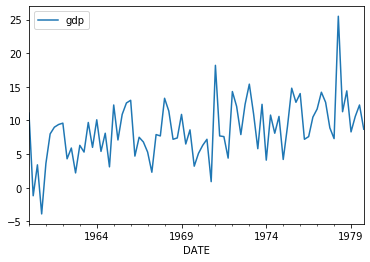

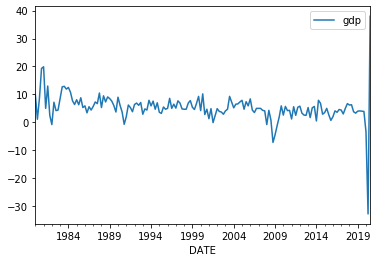

In [18]:
gdp_train_only = gdp[(gdp.index<'1980-03-31')]
sts.adfuller(gdp_train_only)
gdp_train_only.plot()
gdp_train_only

gdp_test_only = gdp[(gdp.index>='1980-03-31')]
sts.adfuller(gdp_test_only)
gdp_test_only.plot()
gdp_test_only

print(len(gdp_train_only), len(gdp_test_only))

In [19]:
gdp_train_only

,gdp
DATE,
1960-03-31,11.1
1960-06-30,-1.2
1960-09-30,3.4
1960-12-31,-3.9
1961-03-31,3.6
...,...
1978-12-31,14.4
1979-03-31,8.3
1979-06-30,10.6


In [20]:
gdp_test_only

,gdp
DATE,
1980-03-31,10.0
1980-06-30,1.1
1980-09-30,8.7
1980-12-31,19.3
1981-03-31,19.9
...,...
2019-09-30,4.0
2019-12-31,3.9
2020-03-31,-3.4


### Use Markov Model to predict regimes for the training data set
### 1960-1979

In [21]:
gdp_train_only_model = sm.tsa.MarkovAutoregression(gdp_train_only, k_regimes=2, order=4, switching_variance=True, 
                                                   switching_ar = False,trend = 'nc')
gdp_train_only_model_res = gdp_train_only_model.fit()
gdp_train_only_model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                      gdp   No. Observations:                   76
Model:             MarkovAutoregression   Log Likelihood                -212.334
Date:                  Tue, 15 Dec 2020   AIC                            440.667
Time:                          09:29:03   BIC                            459.313
Sample:                      03-31-1960   HQIC                           448.119
                           - 12-31-1979                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       101.1495     89.790      1.127      0.260     -74.837     277.135
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        11.2886      2.126      5.309      0.000       7.121      15.456
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3759      0.091      4.144      0.000       0.198       0.554
ar.L2          0.2872      0.097      2.958      0.003       0.097       0.478
ar.L3         -0.0114      0.094     -0.121      0.904      -0.196       0.173
ar.L4          0.2841      0.090      3.170      0.002       0.108       0.460
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     1.203e-07        nan        nan        nan         nan         nan
p[1->0]        0.0776      0.075      1.030      0.303      -0.070       0.225
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

[Text(0.5, 1.0, 'Filtered probability of expansion')]

[Text(0.5, 1.0, 'Filtered probability of recession')]

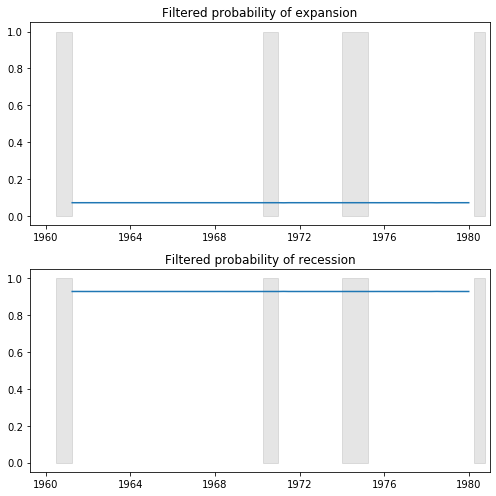

In [22]:
fig, axes = plt.subplots(2, figsize=(7,7))

ax = axes[0]
ax.plot(gdp_train_only_model_res.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of expansion')

ax = axes[1]
ax.plot(gdp_train_only_model_res.filtered_marginal_probabilities[1])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of recession')

fig.tight_layout()

In [23]:
layout1 = go.Layout(
    title = 'Recession Probability', # Graph title
    xaxis = dict(title = 'Years'), # x-axis label
    yaxis = dict(title = 'Filtered Marginal Probability'), # y-axis label
)
fig1 =  go.Figure(layout=layout1)

fig1.add_trace(
    go.Scatter(y=gdp_train_only_model_res.filtered_marginal_probabilities[1],
               x=gdp_train_only.index,
               mode="lines",
   ))
fig1.show()

In [24]:
layout1 = go.Layout(
    title = 'Expansion  Probability', # Graph title
    xaxis = dict(title = 'Years'), # x-axis label
    yaxis = dict(title = 'Filtered Marginal Probability'), # y-axis label
)
fig1 =  go.Figure(layout=layout1)

fig1.add_trace(
    go.Scatter(y=gdp_train_only_model_res.filtered_marginal_probabilities[0],
               x=gdp_train_only.index,
               mode="lines",
   ))
fig1.show()

In [25]:
recession_prob_train = gdp_train_only_model_res.filtered_marginal_probabilities[1]
train_set['recession_prob']= recession_prob_train.round(7).values
print(len(train_set[train_set.recession_prob>0.9281]))
train_set['recession_dummy'] = train_set.recession_prob.apply(lambda x : 1 if x>= 0.9281 else 0)
print(len(train_set[train_set.recession_dummy==1]))
print(len(train_set))

3
3
76


In [26]:
#### Now get the X and Y train values from actual returns and markov predicted y values
x_train = train_set[['gdp_lag_1', 'gdp_lag_2', 'gdp_lag_3', 'gdp_lag_4',
       'equity_qrt_ret_lag_2', 'bond_qrt_ret_lag_2', 'gold_qrt_ret_lag_2']]
y_train = train_set['recession_dummy']

### Use Markov Model to predict regimes for the whole data set
### 1960-2020

243


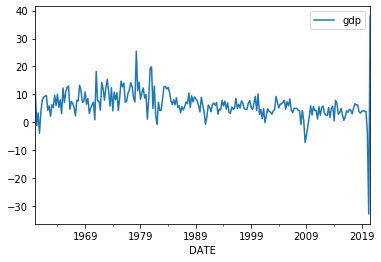

In [27]:
gdp_whole_per = gdp[gdp.index>='1960-03-31']
print(len(gdp_whole_per))
#sts.adfuller(gdp_train_only)
gdp_whole_per.plot()

In [28]:
gdp_complete_model = sm.tsa.MarkovAutoregression(gdp_whole_per, k_regimes=2, order=4, switching_variance=True, 
                                                   switching_ar = False,trend='nc')
gdp_complete_model_res = gdp_complete_model.fit()
gdp_complete_model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                      gdp   No. Observations:                  239
Model:             MarkovAutoregression   Log Likelihood                -633.777
Date:                  Tue, 15 Dec 2020   AIC                           1283.554
Time:                          09:29:08   BIC                           1311.366
Sample:                      03-31-1960   HQIC                          1294.762
                           - 09-30-2020                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.7603      0.816      9.513      0.000       6.162       9.359
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       324.1348    131.610      2.463      0.014      66.185     582.085
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4033      0.061      6.575      0.000       0.283       0.524
ar.L2          0.3030      0.063      4.817      0.000       0.180       0.426
ar.L3          0.0130      0.063      0.209      0.835      -0.110       0.136
ar.L4          0.2205      0.056      3.968      0.000       0.112       0.329
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9767      0.012     81.065      0.000       0.953       1.000
p[1->0]        0.3041      0.150      2.033      0.042       0.011       0.597
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

[Text(0.5, 1.0, 'Filtered probability of expansion')]

[Text(0.5, 1.0, 'Filtered probability of recession')]

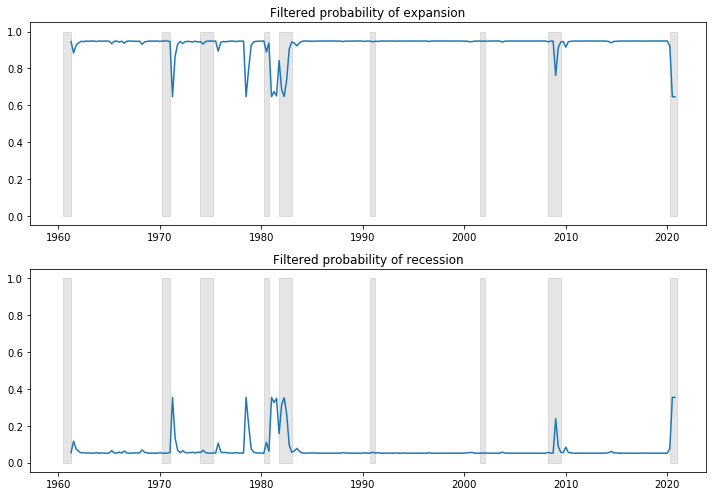

In [29]:
fig, axes = plt.subplots(2, figsize=(10,7))

ax = axes[0]
ax.plot(gdp_complete_model_res.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of expansion')

ax = axes[1]
ax.plot(gdp_complete_model_res.filtered_marginal_probabilities[1])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of recession')

fig.tight_layout()

In [30]:
layout2 = go.Layout(
    title = 'Recession Probability', # Graph title
    xaxis = dict(title = 'Years'), # x-axis label
    yaxis = dict(title = 'Filtered Marginal Probability'), # y-axis label
)
fig2 =  go.Figure(layout=layout2)

fig2.add_trace(
    go.Scatter(y=gdp_complete_model_res.filtered_marginal_probabilities[1],
               x=gdp_whole_per.index,
               mode="lines",
   ))
fig2.show();

In [31]:
recession_prob_test = gdp_complete_model_res.filtered_marginal_probabilities[1].values
test_set['recession_prob'] = recession_prob_test[-len(test_set):].round(4)
test_set['recession_dummy'] = test_set.recession_prob.apply(lambda x : 1 if x>= 0.10 else 0)
print(len(test_set))
print(len(test_set[test_set.recession_dummy==1]))

163
11


In [32]:
x_test = test_set[['gdp_lag_1', 'gdp_lag_2', 'gdp_lag_3', 'gdp_lag_4',
       'equity_qrt_ret_lag_2', 'bond_qrt_ret_lag_2', 'gold_qrt_ret_lag_2']]
y_test = test_set['recession_dummy']

## Step - Four - We now Create a rolling prediction 

In [33]:
x_train_roll = x_train.copy()
y_train_roll = y_train.copy()
x_test_roll = x_test.copy()
y_test_roll = y_test.copy()

In [34]:
print(len(x_train_roll), len(y_train_roll), len(x_test_roll), len(y_test_roll))

76 76 163 163


In [35]:
prediction_list = []
for w in range(len(x_test_roll)):
#     gb = GradientBoostingClassifier(n_estimators=20,learning_rate = 0.75, max_depth = 2, random_state=50)
    gb = GradientBoostingClassifier(n_estimators=200,learning_rate = 0.50, max_depth = 4, random_state=50)
    gb.fit(x_train_roll,y_train_roll)        
    yhat = gb.predict(x_test_roll)[w]
    y_train_roll = np.append(y_train_roll,y_test_roll[w])
    x_train_roll = np.append(x_train_roll, x_test_roll.iloc[w].values.reshape(1,-1), axis=0)
    prediction_list += [yhat]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
df = []
for p in range(len(prediction_list)):
    x = {'date':y_test.index[p],
        'y_predicted':prediction_list[p]}
    df += [x]
df = pd.DataFrame(df)
df.set_index('date',inplace=True)
df['y_test']= y_test

Confusion Matrix:


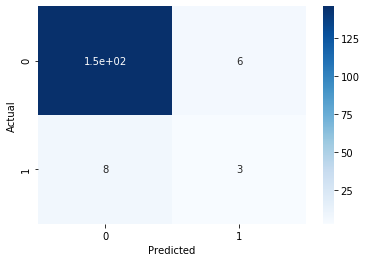

In [37]:
print('Confusion Matrix:')
confusion_matrix = pd.crosstab(df['y_test'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.show()

In [38]:
df

,y_predicted,y_test
date,,
1980-03-31,0,0
1980-06-30,0,1
1980-09-30,1,0
1980-12-31,0,1
1981-03-31,0,1
...,...,...
2019-09-30,0,0
2019-12-31,0,0
2020-03-31,0,0


In [39]:
ret_test = assets_qtr_ret_all[(assets_qtr_ret_all.index>='1980-03-31')&(assets_qtr_ret_all.index<='2020-09-30')]
ret_test['recession_dummy'] = prediction_list
ret_test_recession = ret_test[ret_test.recession_dummy==1]
ret_test_expansion = ret_test[ret_test.recession_dummy==0]

ret_train = assets_qtr_ret_all[(assets_qtr_ret_all.index>='1961-03-31')&(assets_qtr_ret_all.index<='1979-12-31')]
ret_train['recession_dummy'] = train_set['recession_dummy'].values
ret_train_recession = ret_train[ret_train.recession_dummy==1]
ret_train_expansion = ret_train[ret_train.recession_dummy==0]

## Step - Five - We now Create a optimal Portfolio

#### We First Create a Rolling Standard Deviation risk data frame

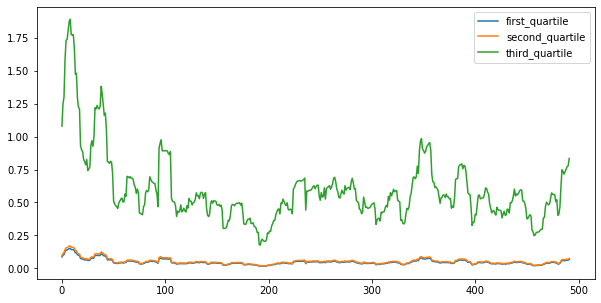

In [40]:
rolling_stds = []
asset_month_ret_for_test = assets_daily_ret_all.copy()
asset_month_ret_for_test = asset_month_ret_for_test[(asset_month_ret_for_test.index>='1980-01-01')&(asset_month_ret_for_test.index<='2020-12-31')]
asset_month_ret_for_test.reset_index(inplace=True)
for x in asset_month_ret_for_test.to_dict('records'):
    sub =  assets_daily_ret_all[assets_daily_ret_all.index < x['Date']].tail(12)
    r_s = {'date' : x['Date'],
        'equity_std' : sub['equity_ret'].std(),
        'bond_std': sub['bond_ret'].std(),
        'gold_std': sub['gold_ret'].std()}
    rolling_stds += [r_s]
    
rolling_stds = pd.DataFrame(rolling_stds)
rolling_stds['min'] = rolling_stds.min(axis=1)
rolling_stds['max'] = rolling_stds.max(axis=1)
rolling_stds['first_quartile'] = (((rolling_stds['max']-rolling_stds['min'])/10)+rolling_stds['min'])*8
rolling_stds['third_quartile'] = (((rolling_stds['max']-rolling_stds['min'])/10)+rolling_stds['min'])*100
rolling_stds['second_quartile'] = (((rolling_stds['max']-rolling_stds['min'])/10)+rolling_stds['min'])*9
rolling_stds = rolling_stds.fillna('0')
rolling_stds.date = pd.to_datetime(rolling_stds.date)
rolling_stds[['first_quartile','second_quartile','third_quartile']].plot(figsize=(10,5))

In [41]:
rolling_stds

,date,equity_std,bond_std,gold_std,min,max,first_quartile,third_quartile,second_quartile
0,1980-01-01,0.038780,0.001542,0.094018,0.001542,0.094018,0.086313,1.078918,0.097103
1,1980-02-01,0.040323,0.001711,0.109240,0.001711,0.109240,0.099713,1.246415,0.112177
2,1980-03-01,0.037802,0.001737,0.114489,0.001737,0.114489,0.104095,1.301192,0.117107
3,1980-04-01,0.048208,0.001910,0.141537,0.001910,0.141537,0.126981,1.587260,0.142853
4,1980-05-01,0.049548,0.003565,0.140913,0.003565,0.140913,0.138397,1.729964,0.155697
...,...,...,...,...,...,...,...,...,...
487,2020-08-01,0.064754,0.000966,0.042890,0.000966,0.064754,0.058760,0.734494,0.066104
488,2020-09-01,0.066291,0.000994,0.041194,0.000994,0.066291,0.060187,0.752334,0.067710
489,2020-10-01,0.068255,0.000989,0.042488,0.000989,0.068255,0.061726,0.771571,0.069441
490,2020-11-01,0.069146,0.000961,0.043048,0.000961,0.069146,0.062235,0.777937,0.070014


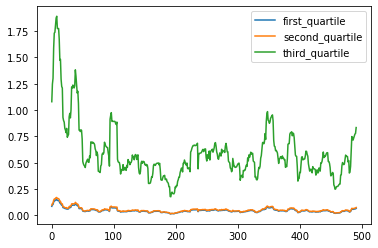

In [42]:
rolling_stds[['first_quartile','second_quartile','third_quartile']].plot()

In [43]:
# import sys
# sys.path.append(r'C:\\Users\\tintin\\AppData\\Local\\Programs\\Python\\Python37\\Library\\bin')
# import cvxopt as opt
def optimal_portfolio(returns, S):
#     n = len(returns)
#     N = 100
#     mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]
#     # Convert to cvxopt matrices
#     pbar = opt.matrix(returns)
#     # Create constraint matrices
#     G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
#     h = opt.matrix(0.0, (n, 1))
#     A = opt.matrix(1.0, (1, n))
#     b = opt.matrix(1.0)
#     # Calculate efficient frontier weights using quadratic programming
#     solvers.options['show_progress'] = False
#     portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
#                   for mu in mus]
#     ## CALCULATE RISKS AND RETURNS FOR FRONTIER
#     returns = []
#     returns = [blas.dot(pbar, x) for x in portfolios]
#     risks = []
#     risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
#     risks = [(sum(risks) / len(risks)) if math.isnan(x) else x for x in risks]
#     ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
#     m1 = np.polyfit(returns, risks, 2)
#     x1 = np.sqrt(abs(m1[2] / m1[0]))
#     # CALCULATE THE OPTIMAL PORTFOLIO
#     solvers.options['show_progress'] = False
#     wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
#     return np.asarray(wt), returns, risks, portfolios


#     n = len(returns)
#     N = 100
#     mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]
#     # Convert to cvxopt matrices
#     pbar = opt.matrix(returns)
#     # Create constraint matrices
#     G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
#     h = opt.matrix(0.0, (n, 1))
#     A = opt.matrix(1.0, (1, n))
#     b = opt.matrix(1.0)
#     # Calculate efficient frontier weights using quadratic programming
#     solvers.options['show_progress'] = False
#     portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
#                   for mu in mus]
#     ## CALCULATE RISKS AND RETURNS FOR FRONTIER
#     returns = []
#     returns = [blas.dot(pbar, x) for x in portfolios]
#     risks = []
#     risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
#     risks = [(sum(risks) / len(risks)) if math.isnan(x) else x for x in risks]
#     ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
#     m1 = np.polyfit(returns, risks, 2)
#     x1 = np.sqrt(abs(m1[2] / m1[0]))
#     # CALCULATE THE OPTIMAL PORTFOLIO
#     solvers.options['show_progress'] = False
#     wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
#     return np.asarray(wt), returns, risks, portfolios
    n = len(returns)

    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    pbar = opt.matrix(returns)

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(abs(m1[2] / m1[0]))
    # CALCULATE THE OPTIMAL PORTFOLIO
    solvers.options['show_progress'] = False
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, portfolios


In [44]:
def find_ret(RISK, RETURN, tgt_risk):
    '''
    RISK is a np.array() of risk levels
    RETURN is a np.array() of associated optimum returns
    '''
    assert len(RISK) == len(RETURN)
    last = None
    for (risk, ret) in zip(RISK, RETURN):
        if risk > tgt_risk:
            return last
        last = ret
    return last

def find_weights(RISK, PORTFOLIOS, tgt_risk):
    '''
    RISK is a np.array() of risk levels
    RETURN is a np.array() of associated optimum returns
    Portfolios is weights
    '''
    assert len(RISK) == len(PORTFOLIOS)
    last = None
    for (risk, w) in zip(RISK, PORTFOLIOS):
        if risk > tgt_risk:
            return last
        last = w
    if (last[0] + last[1] + last[2]) != 1
    last[2] = 1 - ( last[0] + last[1] ) 
    return last


In [45]:
# ret_test.rename(columns={'index':'Date'},inplace=True)
# assets_daily_ret_all.rename(columns={'index':'Date'},inplace=True)
ret_test_temp = ret_test.copy()
assets_daily_ret_all_temp = assets_daily_ret_all.copy()



ret_test_temp.reset_index(inplace = True)
assets_daily_ret_all_temp.reset_index(inplace = True)



ret_lookback=60
cov_lookback=20
mean_lookback_returns = []
quarterly_cov_hat = []

for x in ret_test_temp.to_dict('records'):
    sub = assets_daily_ret_all_temp[assets_daily_ret_all_temp.Date< x['Date']].tail(ret_lookback)
    return_vec = sub[[ 'equity_ret','bond_ret','gold_ret']].mean().values
    if x['recession_dummy'] == 1:
        sigma = opt.matrix(ret_train_recession[['equity_qtr_ret', 'bond_qtr_ret', 'gold_qtr_ret']]\
                           .tail(cov_lookback).astype(float).cov().values)
        ret_train_recession = ret_train_recession.append(x,ignore_index=True)
    else:
        sigma = opt.matrix(ret_train_expansion[['equity_qtr_ret', 'bond_qtr_ret', 'gold_qtr_ret']]\
                           .tail(cov_lookback).astype(float).cov().values)
        ret_train_expansion = ret_train_expansion.append(x,ignore_index=True)
    mean_lookback_returns += [return_vec]
    quarterly_cov_hat += [sigma]
    
    #print(sigma)

In [46]:
# risks_hat = []
# weights_hat = []

# for ret, cov in zip(mean_lookback_returns, quarterly_cov_hat):
#     w, re, ri, p = optimal_portfolio(ret, cov)
#     risks_hat += [ri]
#     weights_hat += [p]

In [47]:
all_asset_ret = assets_daily_ret_all.copy()
sub = all_asset_ret[all_asset_ret.index< '1980-03-31'].tail(12)
return_vec = sub[[ 'equity_ret','bond_ret','gold_ret']].mean().values
sigma = opt.matrix(ret_train_recession[['equity_qtr_ret', 'bond_qtr_ret', 'gold_qtr_ret']]\
                           .tail(cov_lookback).cov().values)
w, re, ri, p = optimal_portfolio(return_vec, sigma)

Text(0, 0.5, 'mean')

Text(0.5, 0, 'std')

Text(0.5, 1.0, 'Covar_regime_switching')

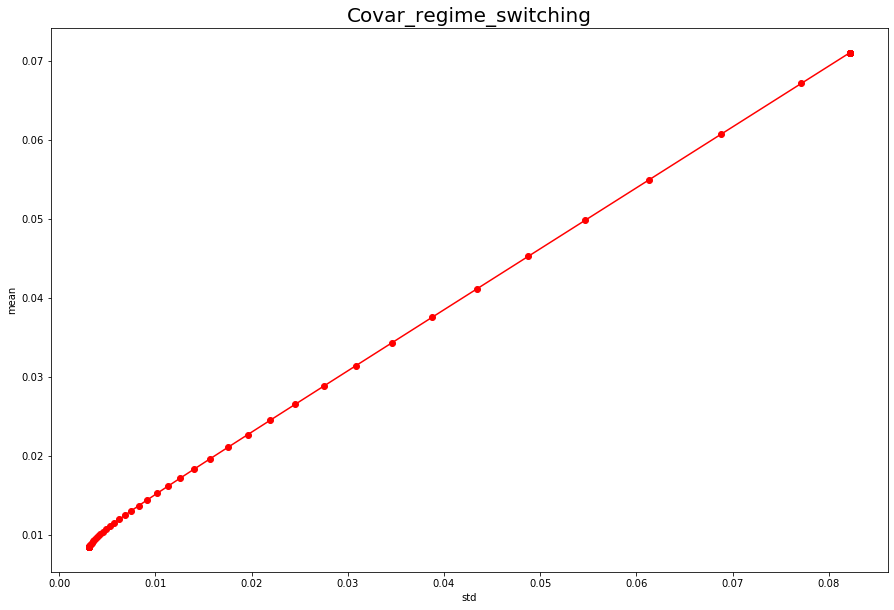

In [48]:
fig = plt.figure(figsize=[15,10])
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(ri, re, 'r-o')
plt.title('Covar_regime_switching',fontsize=20)
plt.show()

In [49]:
all_asset_ret = assets_daily_ret_all.copy()
asset_ret_test = all_asset_ret[all_asset_ret.index>='1980-01-01']
asset_ret_test.reset_index(inplace=True)

In [50]:
# rolling_stds = []
# for x in asset_ret_test.to_dict('records'):
#     #print(x)
#     sub = all_asset_ret[all_asset_ret.index<x['Date']].tail(12)
#     r_s = {'date' : x['Date'],
#         'equity_std' : sub['equity_ret'].std(),
#         'bond_std': sub['bond_ret'].std(),
#         'gold_std': sub['gold_ret'].std()}
#     rolling_stds += [r_s]
# rolling_stds = pd.DataFrame(rolling_stds)
# rolling_stds['min'] = rolling_stds.min(axis=1)
# rolling_stds['max'] = rolling_stds.max(axis=1)
# rolling_stds['first_quartile'] = (((rolling_stds['max']-rolling_stds['min'])/10)+rolling_stds['min'])*8
# rolling_stds['third_quartile'] = (((rolling_stds['max']-rolling_stds['min'])/10)+rolling_stds['min'])*100
# rolling_stds['second_quartile'] = (((rolling_stds['max']-rolling_stds['min'])/10)+rolling_stds['min'])*9
# rolling_stds[['first_quartile','second_quartile','third_quartile']].plot()

In [51]:
risks_hat = []
weights_hat = []
for ret, cov in zip(mean_lookback_returns, quarterly_cov_hat):
        w, re, ri, p = optimal_portfolio(ret, cov)
        risks_hat += [ri]
        weights_hat += [p]
weights_table = []        
for i in range(len(ret_test)):
        table = {'risks': risks_hat[i], 'weights': weights_hat[i]}
        table = pd.DataFrame(table)
        table = table.sort_values(by=['risks'])
#         print(table)
        # low_w = find_weights(table.risks, table.weights, None, 0.01)
        # med_w = find_weights(table.risks, table.weights,0.01, 0.025)
        # high_w = find_weights(table.risks, table.weights, 0.04, None)
#         low_w = find_weights(table.risks, table.weights, np.float(rolling_stds['min'][i]))
#         med_w = find_weights(table.risks, table.weights, np.float(rolling_stds['first_quartile'][i]))
#         high_w = find_weights(table.risks, table.weights, np.float(rolling_stds['second_quartile'][i]))
        low_w = find_weights(table.risks, table.weights, np.float(rolling_stds['first_quartile'][i]))
        med_w = find_weights(table.risks, table.weights, np.float(rolling_stds['second_quartile'][i]))
        high_w = find_weights(table.risks, table.weights, np.float(rolling_stds['third_quartile'][i]))        
#         low_w = find_weights(table.risks, table.weights, table.risks.quantile(q=0.1))
#         med_w = find_weights(table.risks, table.weights, table.risks.quantile(q=0.5))
#         high_w = find_weights(table.risks, table.weights,table.risks.quantile(q=0.9))
        g = {'equity_low_w_hat': np.float(low_w[0]),
             'bond_low_w_hat': np.float(low_w[1]),
             'gold_low_w_hat': np.float(low_w[2]),
             'equity_med_w_hat': np.float(med_w[0]),
             'bond_med_w_hat': np.float(med_w[1]),
             'gold_med_w_hat': np.float(med_w[2]),
             'equity_high_w_hat': np.float(high_w[0]),
             'bond_high_w_hat': np.float(high_w[1]),
             'gold_high_w_hat': np.float(high_w[2])}
        weights_table += [g]
weights_table = pd.DataFrame(weights_table)
weights_table['calculation_date'] = ret_test.index
weights_table['year'] = weights_table['calculation_date'].dt.year
weights_table['month'] = weights_table['calculation_date'].dt.month
weights_table['quarter'] = weights_table.month.apply(
     lambda v: 'Q1' if v <= 3 else 'Q2' if v <= 6 else 'Q3' if v <= 9 else 'Q4')
weights_table['year_quarter'] = weights_table.year.astype(str) + '-' + weights_table.quarter.astype(str)
    # weights_table = weights_table.drop(['year','month','quarter'], axis = 0)
weights_table.set_index('year_quarter', inplace=True)
weights_table = weights_table.fillna('0')    

In [52]:
len(weights_table)

163

### Now deal with Historical Data

In [53]:
ret_test_temp_his = ret_test.copy()
assets_daily_ret_all_temp_his = assets_daily_ret_all.copy()

quarterly_asset_ret = assets_qtr_ret_all.copy()


ret_test_temp_his.reset_index(inplace = True)
assets_daily_ret_all_temp_his.reset_index(inplace = True)
quarterly_asset_ret.reset_index(inplace = True)

ret_lookback=60
mean_lookback_returns = []
quarterly_cov_his = []
cov_lookback = 20

for x in ret_test_temp_his.to_dict('records'):
    sub = assets_daily_ret_all_temp_his[assets_daily_ret_all_temp_his['Date']< x['Date']].tail(ret_lookback)
    return_vec = sub[[ 'equity_ret','bond_ret','gold_ret']].astype(np.float).mean().values
    sigma = opt.matrix(quarterly_asset_ret[quarterly_asset_ret['Date']<x['Date']].tail(cov_lookback).astype(np.float).cov().values)
    mean_lookback_returns += [return_vec]
    quarterly_cov_his += [sigma]
#     print(sigma)

In [54]:
# risks_his = []
# weights_his = []

# for ret, cov in zip(mean_lookback_returns, quarterly_cov_his):
#     w, re, ri, p = optimal_portfolio(ret, cov)
#     risks_his += [ri]
#     weights_his += [p]

In [55]:
sub = all_asset_ret[all_asset_ret.index< '1980-03-31'].tail(12)
return_vec = sub[[ 'equity_ret','bond_ret','gold_ret']].mean().values
sigma = opt.matrix(sub[[ 'equity_ret','bond_ret','gold_ret']].cov().values)
w, re, ri, p = optimal_portfolio(return_vec, sigma)

Text(0, 0.5, 'mean')

Text(0.5, 0, 'std')

Text(0.5, 1.0, 'Covar_regime_switching')

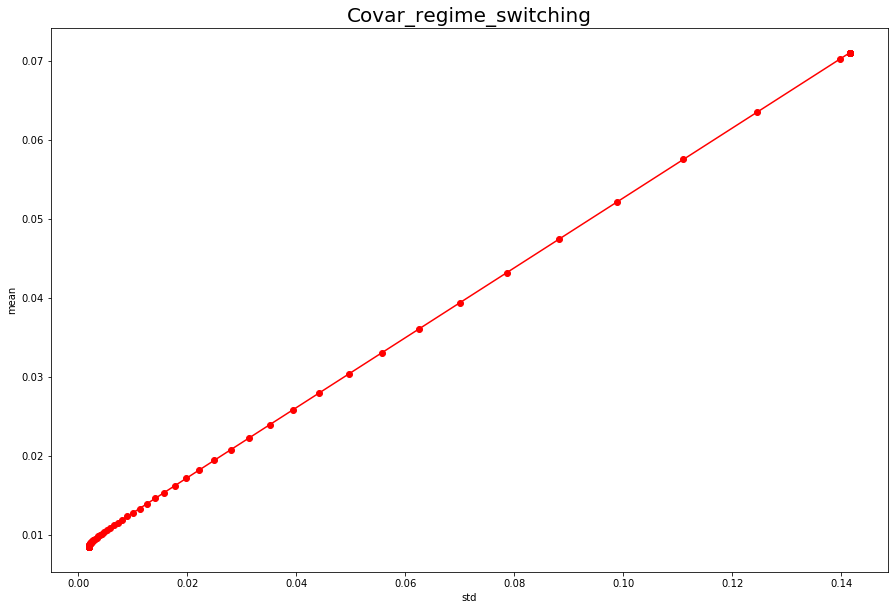

In [56]:
fig = plt.figure(figsize=[15,10])
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(ri, re, 'r-o')
plt.title('Covar_regime_switching',fontsize=20)
plt.show()

In [57]:
risks_his = []
weights_his = []

for ret, cov in zip(mean_lookback_returns, quarterly_cov_his):
    w, re, ri, p = optimal_portfolio(ret, cov)
    risks_his += [ri]
    weights_his += [p]
    weights_table_his = []
for i in range(len(ret_test)):
    table = {'risks': risks_his[i], 'weights': weights_his[i]}
    table = pd.DataFrame(table)
    table = table.sort_values(by=['risks'])
#     low_w = find_weights(table.risks, table.weights, np.float(rolling_stds['min'][i]))
#     med_w = find_weights(table.risks, table.weights, np.float(rolling_stds['first_quartile'][i]))
#     high_w = find_weights(table.risks, table.weights, np.float(rolling_stds['second_quartile'][i]))
    low_w = find_weights(table.risks, table.weights, np.float(rolling_stds['first_quartile'][i]))
    med_w = find_weights(table.risks, table.weights, np.float(rolling_stds['second_quartile'][i]))
    high_w = find_weights(table.risks, table.weights, np.float(rolling_stds['third_quartile'][i]))  
#     low_w = find_weights(table.risks, table.weights, table.risks.quantile(q=0.1))
#     med_w = find_weights(table.risks, table.weights, table.risks.quantile(q=0.5))
#     high_w = find_weights(table.risks, table.weights,table.risks.quantile(q=0.9)) 
    g = {'equity_low_w_his': float(low_w[0]),
         'bond_low_w_his': float(low_w[1]),
         'gold_low_w_his': float(low_w[2]),
         'equity_med_w_his': float(med_w[0]),
         'bond_med_w_his': float(med_w[1]),
         'gold_med_w_his': float(med_w[2]),
         'equity_high_w_his': float(high_w[0]),
         'bond_high_w_his': float(high_w[1]),
         'gold_high_w_his': float(high_w[2])}
    weights_table_his += [g]
weights_table_his = pd.DataFrame(weights_table_his)
weights_table_his['calculation_date'] = ret_test.index
weights_table_his['year'] = weights_table_his['calculation_date'].dt.year
weights_table_his['month'] = weights_table_his['calculation_date'].dt.month
weights_table_his['quarter'] = weights_table_his.month.apply(
   lambda v: 'Q1' if v <= 3 else 'Q2' if v <= 6 else 'Q3' if v <= 9 else 'Q4')
weights_table_his['year_quarter'] = weights_table_his.year.astype(str) + '-' + weights_table_his.quarter.astype(str)
weights_table_his.set_index('year_quarter', inplace=True)
weights_table_his = weights_table_his.fillna('0')   

In [58]:
len(weights_table_his)

163

In [59]:
def dailyportfolioreturn(returns_act, weights_table_hat, weights_table_his):
#     returns_act = returns_act[start_date:end_date]  # Add one more qtr end here
#     weights_table_his = weights_table_his.drop(['year', 'month', 'quarter'], axis=1)
#     weights_table_hat = weights_table_hat.drop(['year', 'month', 'quarter', 'calculation_date'], axis=1)
#     weights_table_LR  = weights_table_LR.drop(['year', 'month', 'quarter'], axis=1)

    final_csv_temp = pd.merge(left=returns_act.reset_index(), right=weights_table_his, left_on='year_quarter',
                              right_on='year_quarter').set_index(['Date'])

    final_csv_output = pd.merge(left=final_csv_temp.reset_index(), right=weights_table_hat, left_on='year_quarter',
                                right_on='year_quarter').set_index(['Date'])

    final_csv_output = final_csv_output.drop(['year', 'month', 'quarter', 'year_quarter'], axis=1)

    return_arr = np.array(
        final_csv_output[['equity_ret', 'bond_ret', 'gold_ret']].T, dtype=float)

    final_csv_output['ret_low_his'] = np.einsum("ij,ij->j", return_arr
                                                , np.array(
            final_csv_output[['equity_low_w_his', 'bond_low_w_his', 'gold_low_w_his']].T,
            dtype=float))

    final_csv_output['ret_med_his'] = np.einsum("ij,ij->j", return_arr
                                                , np.array(
            final_csv_output[['equity_med_w_his', 'bond_med_w_his', 'gold_med_w_his']].T,
            dtype=float))
    final_csv_output['ret_high_his'] = np.einsum("ij,ij->j", return_arr
                                                 , np.array(
            final_csv_output[['equity_high_w_his', 'bond_high_w_his', 'gold_high_w_his']].T,
            dtype=float))

    final_csv_output['ret_low_hat'] = np.einsum("ij,ij->j", return_arr
                                                , np.array(
            final_csv_output[['equity_low_w_hat', 'bond_low_w_hat', 'gold_low_w_hat']].T,
            dtype=float))
    final_csv_output['ret_med_hat'] = np.einsum("ij,ij->j", return_arr
                                                , np.array(
            final_csv_output[['equity_med_w_hat', 'bond_med_w_hat', 'gold_med_w_hat']].T,
            dtype=float))
    final_csv_output['ret_high_hat'] = np.einsum("ij,ij->j", return_arr
                                                 , np.array(
            final_csv_output[['equity_high_w_hat', 'bond_high_w_hat', 'gold_high_w_hat']].T,
            dtype=float))


    return (final_csv_output)

In [60]:
assets_daily_ret = assets_daily_ret_all.copy()
assets_daily_ret = assets_daily_ret[assets_daily_ret.index>='1980']
assets_daily_ret['year'] = assets_daily_ret.index.year
assets_daily_ret['month'] = assets_daily_ret.index.month
assets_daily_ret['quarter'] = assets_daily_ret.month.apply(
   lambda v: 'Q1' if v <= 3 else 'Q2' if v <= 6 else 'Q3' if v <= 9 else 'Q4')
assets_daily_ret['year_quarter'] = assets_daily_ret.year.astype(str) + '-' + assets_daily_ret.quarter.astype(str)
result_ret = dailyportfolioreturn(assets_daily_ret, weights_table, weights_table_his)
result_ret['year_qtr'] = result_ret['year_x'].astype(str) + '-' + result_ret.quarter_x.astype(str)

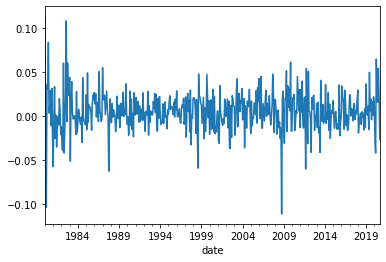

In [61]:
all_asset_ret = assets_daily_ret_all.copy()
all_asset_ret = all_asset_ret.loc[:,['equity_ret','bond_ret','gold_ret']][all_asset_ret.index>='1980-01-01']
all_asset_ret.index.name = 'date'
asset_ret = all_asset_ret[(all_asset_ret.index>='1980-01-01') & (all_asset_ret.index<'2020-10-01')]
asset_ret['equal_weight'] = np.float(0.33)
asset_ret['weighted_ret_equity'] = asset_ret['equal_weight'] * asset_ret['equity_ret']
asset_ret['weighted_ret_bond'] = asset_ret['equal_weight'] * asset_ret['bond_ret']
asset_ret['weighted_ret_gc'] = asset_ret['equal_weight'] * asset_ret['gold_ret']
asset_ret['ret'] = (asset_ret['weighted_ret_equity'] + asset_ret['weighted_ret_bond'] + \
asset_ret['weighted_ret_gc']).astype(np.float64)
asset_ret = asset_ret[['equity_ret', 'bond_ret', 'gold_ret','equal_weight','ret']]
asset_ret.ret.plot()

In [62]:
sharpe_ret = assets_daily_ret_all.copy()
# sharpe_ret.reset_index(inplace=True)
sharpe_ret = sharpe_ret['1979-12-31':'2020-12-31'][['equity_ret','bond_ret','gold_ret']]
sharpe_std = rolling_stds.copy()
sharpe_ratio = sharpe_ret.copy()

In [63]:
assets_daily_ret_all

,equity_ret,bond_ret,gold_ret
Date,,,
1960-01-01,-0.071464,NaN,0.004843
1960-02-01,0.009171,0.003096,0.000000
1960-03-01,-0.013899,0.005340,0.000000
1960-04-01,-0.017528,0.002552,0.000000
1960-05-01,0.026853,0.002385,0.000000
...,...,...,...
2020-08-01,0.070065,0.000051,-0.004079
2020-09-01,-0.039228,0.000097,-0.041661
2020-10-01,-0.027666,0.000073,-0.003717


In [64]:
sharpe_std

,date,equity_std,bond_std,gold_std,min,max,first_quartile,third_quartile,second_quartile
0,1980-01-01,0.038780,0.001542,0.094018,0.001542,0.094018,0.086313,1.078918,0.097103
1,1980-02-01,0.040323,0.001711,0.109240,0.001711,0.109240,0.099713,1.246415,0.112177
2,1980-03-01,0.037802,0.001737,0.114489,0.001737,0.114489,0.104095,1.301192,0.117107
3,1980-04-01,0.048208,0.001910,0.141537,0.001910,0.141537,0.126981,1.587260,0.142853
4,1980-05-01,0.049548,0.003565,0.140913,0.003565,0.140913,0.138397,1.729964,0.155697
...,...,...,...,...,...,...,...,...,...
487,2020-08-01,0.064754,0.000966,0.042890,0.000966,0.064754,0.058760,0.734494,0.066104
488,2020-09-01,0.066291,0.000994,0.041194,0.000994,0.066291,0.060187,0.752334,0.067710
489,2020-10-01,0.068255,0.000989,0.042488,0.000989,0.068255,0.061726,0.771571,0.069441
490,2020-11-01,0.069146,0.000961,0.043048,0.000961,0.069146,0.062235,0.777937,0.070014


In [65]:
sharpe_ratio

,equity_ret,bond_ret,gold_ret
Date,,,
1980-01-01,0.057625,0.010605,0.275391
1980-02-01,-0.004380,0.007154,-0.024502
1980-03-01,-0.101795,0.011131,-0.223705
1980-04-01,0.041140,0.018984,0.047523
1980-05-01,0.046571,0.013218,0.033784
...,...,...,...
2020-08-01,0.070065,0.000051,-0.004079
2020-09-01,-0.039228,0.000097,-0.041661
2020-10-01,-0.027666,0.000073,-0.003717


In [66]:
sharpe_ratio['equity_std'] = sharpe_std['equity_std'].values
sharpe_ratio['bond_std'] = sharpe_std['bond_std'].values
sharpe_ratio['gold_std'] = sharpe_std['gold_std'].values


sharpe_ratio['equity_sharpe'] = sharpe_ratio['equity_ret']/sharpe_ratio['equity_std']
sharpe_ratio['bond_sharpe'] = sharpe_ratio['bond_ret']/sharpe_ratio['bond_std']
sharpe_ratio['gold_sharpe'] = sharpe_ratio['gold_ret']/sharpe_ratio['gold_std']

sharpe_ratio['Date'] = rolling_stds['date'].values
sharpe_ratio.set_index('Date',inplace=True)



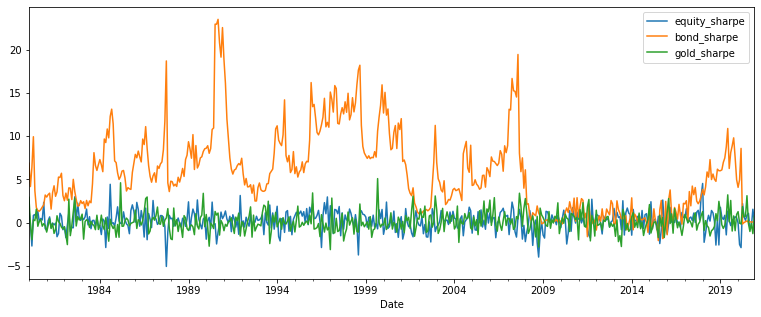

In [67]:
sharpe_ratio[['equity_sharpe','bond_sharpe','gold_sharpe']].plot(figsize=(13,5))

## Last Step :- Analysis

In [68]:
def get_drawdown(R):
    Drawdown_percent = []
    for x in range(len(R)):
        #print(x)
        peak = max(R[0:x+1])
        drawdown_value = peak - R[x]
        drawdown_percent = drawdown_value/R[x]
        #print(drawdown_percent)
        Drawdown_percent += [drawdown_percent]
    return max(Drawdown_percent)

In [69]:
def compound_ret(R):
    com_r = []
    c_r = 100
    for x in R:
        compounded = c_r*x
        c_r = compounded + c_r
        com_r += [c_r]   
    return com_r

def get_summary_metrics(R,rf_annual=0.01, show=False):
    pt = prettytable.PrettyTable(['metric', 'value'])
    print(type(R))
    avg = np.mean(R)
    std_dev = np.std(R)
    rf = rf_annual / 12
    count = len(R)
    sharpe = avg / std_dev * np.sqrt(12)

    avg_annualized_return = (((1 + avg) ** 12) - 1)
    geo_mean = gmean(R + 1) - 1
    annualized_std = std_dev * np.sqrt(12)

    cumulative_end_return = np.cumsum(R).tail(1).values

    win = len(R[R >= 0])
    loss = len(R[R < 0])
    win_loss = win / loss
    win_ratio = win / (loss + win)

    rpt = {'avg_annualized_ret': round(avg_annualized_return,ndigits=4),
           'annualized_std': round(annualized_std,ndigits=4),
           #'geometric_mean': geo_mean,
           #'cum_end_return': cumulative_end_return,
           'mean': round(avg,ndigits=4),
           'std_dev': round(std_dev, ndigits=4),
           'Sharpe_ratio': round(sharpe, ndigits=4),
           #'skewness': R.skew(),
           #'kurtosis': R.kurtosis(),
           'max_drawdown': round(get_drawdown(compound_ret(R)),ndigits=4),
           #'win_loss': win_loss,
           'win_ratio': round(win_ratio,ndigits=4)
            #'count': count
           }
    for (k, v) in rpt.items():
        pt.add_row([k, v])

    if show:
        print(pt)

    return rpt

In [70]:
initial_investment = 1.0

In [71]:
# def apply_cumsum(returns_series):
#     com_r = []
#     c_r = 100
#     for x in returns_series:
#         compounded = c_r*x
#         c_r = compounded + c_r
#         com_r += [c_r]
    
#     return com_r

In [72]:
returns = result_ret.copy()
returns['ret_low_his_cum'] = compound_ret(returns.ret_low_his)
returns['ret_low_hat_cum'] = compound_ret(returns.ret_low_hat)

returns['ret_med_his_cum'] = compound_ret(returns.ret_med_his)
returns['ret_med_hat_cum'] = compound_ret(returns.ret_med_hat)

returns['ret_high_his_cum'] = compound_ret(returns.ret_med_his)
returns['ret_high_hat_cum'] = compound_ret(returns.ret_med_hat)

returns['equal_ret_cum'] = compound_ret(asset_ret.ret)
returns['equal_ret'] = asset_ret.ret

In [73]:
rpt_hat_low = get_summary_metrics(result_ret['ret_low_hat'])
rpt_hat_med = get_summary_metrics(result_ret['ret_med_hat'])
rpt_hat_high = get_summary_metrics(result_ret['ret_high_hat'])

rpt_his_low = get_summary_metrics(result_ret['ret_high_his'])
rpt_his_med = get_summary_metrics(result_ret['ret_med_his'])
rpt_his_high = get_summary_metrics(result_ret['ret_high_his'])

rpt_equal_w = get_summary_metrics(asset_ret['ret'])

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [74]:
returns.to_csv('returns_file2.csv')

In [75]:
def compare(rpt_his_low,rpt_hat_low, rpt_equal_w):
    table_low = prettytable.PrettyTable(['metric', 'covar_his', 'covar_regime-switch','equal_weight'])
    for (k, v) in rpt_his_low.items():
        row = [k, v, rpt_hat_low[k],rpt_equal_w[k]]
        table_low.add_row(row)
    print(table_low)
    return table_low

In [76]:
mean_hat_10 = np.mean(returns.ret_low_hat)
mean_hat_20 = np.mean(returns.ret_med_hat)
mean_hat_30 = np.mean(returns.ret_high_hat)

mean_his_10 = np.mean(returns.ret_low_his)
mean_his_20 = np.mean(returns.ret_med_his)
mean_his_30 = np.mean(returns.ret_high_his)

In [77]:
std_hat_10 = np.std(returns.ret_low_hat)
std_hat_20 = np.std(returns.ret_med_hat)
std_hat_30 = np.std(returns.ret_high_hat)

std_his_10 = np.std(returns.ret_low_his)
std_his_20 = np.std(returns.ret_med_his)
std_his_30 = np.std(returns.ret_high_his)

In [78]:
mean_hat = [mean_hat_10,mean_hat_20,mean_hat_30]
mean_his = [mean_his_10,mean_his_20,mean_his_30]
std_hat = [std_hat_10,std_hat_20,std_hat_30]
std_his = [std_his_10,std_his_20,std_his_30]

In [79]:
rpt = pd.DataFrame(list(zip(mean_hat,mean_his,std_hat,std_his)),columns=['mean_hat','mean_his','std_hat','std_his'])
rpt

,mean_hat,mean_his,std_hat,std_his
0,0.007173,0.007278,0.039217,0.038627
1,0.007636,0.007529,0.041940,0.041633
2,0.009518,0.009523,0.050973,0.050982


In [80]:
rpt.to_csv('rpt2.csv')

In [81]:
print('Summary metrics for Low Risk Level')
compare(rpt_his_low,rpt_hat_low,rpt_equal_w)

Summary metrics for Low Risk Level
+--------------------+-----------+---------------------+--------------+
|       metric       | covar_his | covar_regime-switch | equal_weight |
+--------------------+-----------+---------------------+--------------+
| avg_annualized_ret |   0.1205  |        0.0896       |    0.0632    |
|   annualized_std   |   0.1766  |        0.1359       |    0.0778    |
|        mean        |   0.0095  |        0.0072       |    0.0051    |
|      std_dev       |   0.051   |        0.0392       |    0.0224    |
|    Sharpe_ratio    |   0.6471  |        0.6336       |    0.7898    |
|    max_drawdown    |    1.1    |        0.9869       |    0.2469    |
|     win_ratio      |   0.6299  |        0.6299       |    0.6012    |
+--------------------+-----------+---------------------+--------------+


In [82]:
print('Summary metrics for Med Risk Level')
compare(rpt_his_med,rpt_hat_med,rpt_equal_w)

Summary metrics for Med Risk Level
+--------------------+-----------+---------------------+--------------+
|       metric       | covar_his | covar_regime-switch | equal_weight |
+--------------------+-----------+---------------------+--------------+
| avg_annualized_ret |   0.0942  |        0.0956       |    0.0632    |
|   annualized_std   |   0.1442  |        0.1453       |    0.0778    |
|        mean        |   0.0075  |        0.0076       |    0.0051    |
|      std_dev       |   0.0416  |        0.0419       |    0.0224    |
|    Sharpe_ratio    |   0.6265  |        0.6307       |    0.7898    |
|    max_drawdown    |   1.0856  |        1.0617       |    0.2469    |
|     win_ratio      |   0.6278  |        0.6299       |    0.6012    |
+--------------------+-----------+---------------------+--------------+


In [83]:
print('Summary metrics for High Risk Level')
compare(rpt_his_high,rpt_hat_high,rpt_equal_w)

Summary metrics for High Risk Level
+--------------------+-----------+---------------------+--------------+
|       metric       | covar_his | covar_regime-switch | equal_weight |
+--------------------+-----------+---------------------+--------------+
| avg_annualized_ret |   0.1205  |        0.1204       |    0.0632    |
|   annualized_std   |   0.1766  |        0.1766       |    0.0778    |
|        mean        |   0.0095  |        0.0095       |    0.0051    |
|      std_dev       |   0.051   |        0.051        |    0.0224    |
|    Sharpe_ratio    |   0.6471  |        0.6469       |    0.7898    |
|    max_drawdown    |    1.1    |         1.1         |    0.2469    |
|     win_ratio      |   0.6299  |        0.6299       |    0.6012    |
+--------------------+-----------+---------------------+--------------+


In [84]:
# final_csv_output_plt = returns[[col for col in returns.columns if col.startswith('ret_')]]
final_csv_output_plt = returns
final_csv_output_plt['year'] = returns.index.year
xmin = final_csv_output_plt.year.unique().min()
xmax = final_csv_output_plt.year.unique().max()
slider = widgets.FloatRangeSlider(
    min=xmin,
    max=xmax,
    step=1,
    readout=True,
    readout_format='d',
    orientation='horizontal',
    description='Year')
slider.layout.width = '900px'
def update_plot(y):
    filtered_df = final_csv_output_plt.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
#     df_equal = asset_ret.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
    pyo.iplot(go.Figure(data=[
    go.Scatter(x=filtered_df.index, y =np.cumsum(filtered_df.ret_low_hat),mode = 'lines',name = 'Regime Switch'),
    go.Scatter(x=filtered_df.index,y = np.cumsum(filtered_df.ret_low_his),mode = 'lines',name = 'Historical'),
    go.Scatter(x=filtered_df.index,y = np.cumsum(filtered_df.equal_ret),mode = 'lines',name = 'Equal Weight'),
    ],
    layout=go.Layout(xaxis = dict(title = 'Year'), yaxis = dict(title = 'Return'),title = 'Low Risk Portfolio Return from Year ' + str(int(y[0])) + ' To ' + str(int(y[1])))))
widgets.interact(update_plot, y=slider, continuous_update=False);

interactive(children=(FloatRangeSlider(value=(1990.0, 2010.0), description='Year', layout=Layout(width='900px'…

In [85]:
# final_csv_output_plt = returns[[col for col in returns.columns if col.startswith('ret_')]]
final_csv_output_plt = returns
final_csv_output_plt['year'] = returns.index.year
xmin = final_csv_output_plt.year.unique().min()
xmax = final_csv_output_plt.year.unique().max()
slider = widgets.FloatRangeSlider(
    min=xmin,
    max=xmax,
    step=1,
    readout=True,
    readout_format='d',
    orientation='horizontal',
    description='Year')
slider.layout.width = '900px'
def update_plot(y):
    filtered_df = final_csv_output_plt.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
#     df_equal = asset_ret.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
    pyo.iplot(go.Figure(data=[
    go.Scatter(x=filtered_df.index, y = np.cumsum(filtered_df.ret_med_hat),mode = 'lines',name = 'Regime Switch'),
    go.Scatter(x=filtered_df.index,y = np.cumsum(filtered_df.ret_med_his),mode = 'lines',name = 'Historical'),
    go.Scatter(x=filtered_df.index,y = np.cumsum(filtered_df.equal_ret),mode = 'lines',name = 'Equal Weight'),
    ],
    layout=go.Layout(xaxis = dict(title = 'Year'), yaxis = dict(title = 'Return'),title = 'Medium Risk Portfolio Return from Year ' + str(int(y[0])) + ' To ' + str(int(y[1])))))
widgets.interact(update_plot, y=slider, continuous_update=False);


interactive(children=(FloatRangeSlider(value=(1990.0, 2010.0), description='Year', layout=Layout(width='900px'…

In [86]:
# final_csv_output_plt = returns[[col for col in returns.columns if col.startswith('ret_')]]
final_csv_output_plt = returns
final_csv_output_plt['year'] = returns.index.year
xmin = final_csv_output_plt.year.unique().min()
xmax = final_csv_output_plt.year.unique().max()
slider = widgets.FloatRangeSlider(
    min=xmin,
    max=xmax,
    step=1,
    readout=True,
    readout_format='d',
    orientation='horizontal',
    description='Year')
slider.layout.width = '900px'
def update_plot(y):
    filtered_df = final_csv_output_plt.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
#     df_equal = asset_ret.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
    pyo.iplot(go.Figure(data=[
    go.Scatter(x=filtered_df.index, y = np.cumsum(filtered_df.ret_high_hat),mode = 'lines',name = 'Regime Switch'),
    go.Scatter(x=filtered_df.index,y = np.cumsum(filtered_df.ret_high_his),mode = 'lines',name = 'Historical'),
    go.Scatter(x=filtered_df.index,y = np.cumsum(filtered_df.equal_ret),mode = 'lines',name = 'Equal Weight'),
    ],
    layout=go.Layout(xaxis = dict(title = 'Year'), yaxis = dict(title = 'Return'),title = 'High Risk Portfolio Return from Year ' + str(int(y[0])) + ' To ' + str(int(y[1])))))
widgets.interact(update_plot, y=slider, continuous_update=False);

interactive(children=(FloatRangeSlider(value=(1990.0, 2010.0), description='Year', layout=Layout(width='900px'…

In [87]:
# final_csv_output_plt = returns[[col for col in returns.columns if col.startswith('ret_')]]
final_csv_output_plt = returns
final_csv_output_plt['year'] = returns.index.year
xmin = final_csv_output_plt.year.unique().min()
xmax = final_csv_output_plt.year.unique().max()
slider = widgets.FloatRangeSlider(
    min=xmin,
    max=xmax,
    step=1,
    readout=True,
    readout_format='d',
    orientation='horizontal',
    description='Year')
slider.layout.width = '900px'
def update_plot(y):
    filtered_df = final_csv_output_plt.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
#     df_equal = asset_ret.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
    pyo.iplot(go.Figure(data=[
    go.Scatter(x=filtered_df.index, y =filtered_df.ret_low_hat_cum,mode = 'lines',name = 'Regime Switch'),
    go.Scatter(x=filtered_df.index,y = filtered_df.ret_low_his_cum,mode = 'lines',name = 'Historical'),
    go.Scatter(x=filtered_df.index,y = filtered_df.equal_ret_cum,mode = 'lines',name = 'Equal Weight'),
    ],
    layout=go.Layout(xaxis = dict(title = 'Year'), yaxis = dict(title = 'Return($)'),title = 'Low Risk Portfolio Return from Year ' + str(int(y[0])) + ' To ' + str(int(y[1])))))
widgets.interact(update_plot, y=slider, continuous_update=False);

interactive(children=(FloatRangeSlider(value=(1990.0, 2010.0), description='Year', layout=Layout(width='900px'…

In [88]:
# final_csv_output_plt = returns[[col for col in returns.columns if col.startswith('ret_')]]
final_csv_output_plt = returns
final_csv_output_plt['year'] = returns.index.year
xmin = final_csv_output_plt.year.unique().min()
xmax = final_csv_output_plt.year.unique().max()
slider = widgets.FloatRangeSlider(
    min=xmin,
    max=xmax,
    step=1,
    readout=True,
    readout_format='d',
    orientation='horizontal',
    description='Year')
slider.layout.width = '900px'
def update_plot(y):
    filtered_df = final_csv_output_plt.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
#     df_equal = asset_ret.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
    pyo.iplot(go.Figure(data=[
    go.Scatter(x=filtered_df.index, y =filtered_df.ret_med_hat_cum,mode = 'lines',name = 'Regime Switch'),
    go.Scatter(x=filtered_df.index,y = filtered_df.ret_med_his_cum,mode = 'lines',name = 'Historical'),
    go.Scatter(x=filtered_df.index,y = filtered_df.equal_ret_cum,mode = 'lines',name = 'Equal Weight'),
    ],
    layout=go.Layout(xaxis = dict(title = 'Year'), yaxis = dict(title = 'Return($)'),title = 'Medium Risk Portfolio Return from Year ' + str(int(y[0])) + ' To ' + str(int(y[1])))))
widgets.interact(update_plot, y=slider, continuous_update=False);

interactive(children=(FloatRangeSlider(value=(1990.0, 2010.0), description='Year', layout=Layout(width='900px'…

In [89]:
# final_csv_output_plt = returns[[col for col in returns.columns if col.startswith('ret_')]]
final_csv_output_plt = returns
final_csv_output_plt['year'] = returns.index.year
xmin = final_csv_output_plt.year.unique().min()
xmax = final_csv_output_plt.year.unique().max()
slider = widgets.FloatRangeSlider(
    min=xmin,
    max=xmax,
    step=1,
    readout=True,
    readout_format='d',
    orientation='horizontal',
    description='Year')
slider.layout.width = '900px'
def update_plot(y):
    filtered_df = final_csv_output_plt.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
#     df_equal = asset_ret.query( 'year>= ' + str(y[0]) +'and year<= ' + str(y[1]) )
    pyo.iplot(go.Figure(data=[
    go.Scatter(x=filtered_df.index, y =filtered_df.ret_high_hat_cum,mode = 'lines',name = 'Regime Switch'),
    go.Scatter(x=filtered_df.index,y = filtered_df.ret_high_his_cum,mode = 'lines',name = 'Historical'),
    go.Scatter(x=filtered_df.index,y = filtered_df.equal_ret_cum,mode = 'lines',name = 'Equal Weight'),
    ],
    layout=go.Layout(xaxis = dict(title = 'Year'), yaxis = dict(title = 'Return($)'),title = 'High Risk Portfolio Return from Year ' + str(int(y[0])) + ' To ' + str(int(y[1])))))
widgets.interact(update_plot, y=slider, continuous_update=False);

interactive(children=(FloatRangeSlider(value=(1990.0, 2010.0), description='Year', layout=Layout(width='900px'…

Text(0.5, 1.0, 'Markov model cov - Low risk level')

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Weights')

Text(0.5, 1.0, 'Historical cov - Low risk level')

Text(0.5, 0, 'Years')

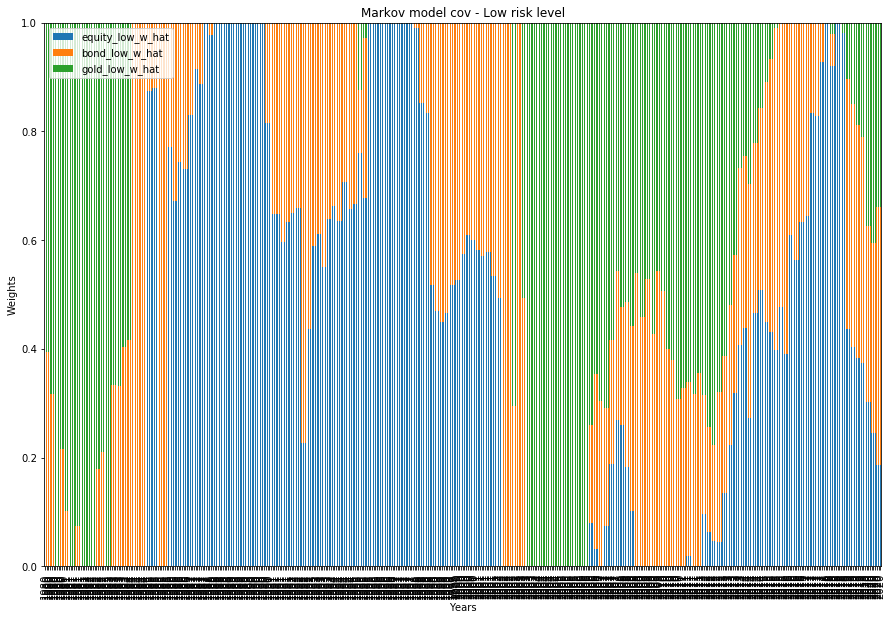

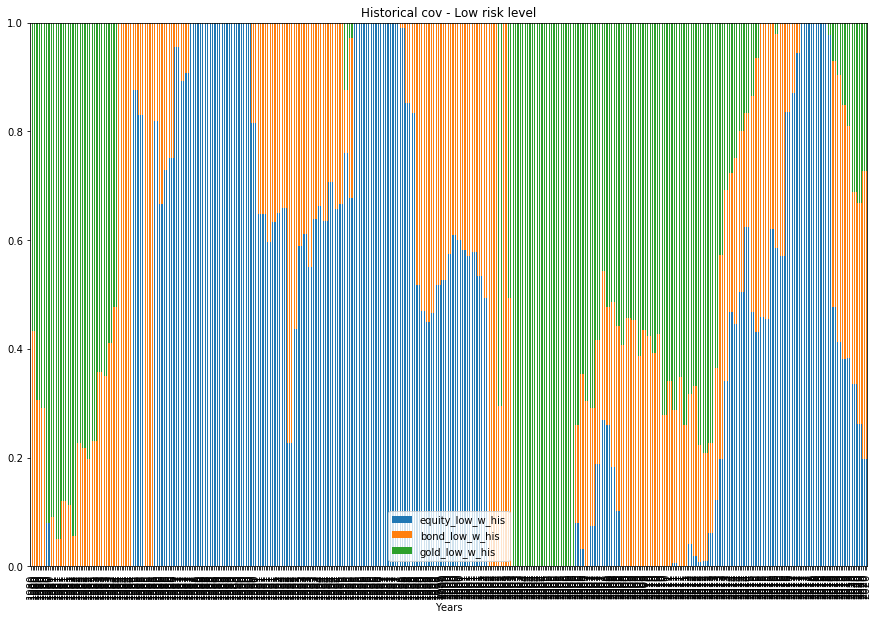

In [90]:
returns.plot(
    x="year_x", y=['equity_low_w_hat', 'bond_low_w_hat', 'gold_low_w_hat'],kind='bar', stacked=True, figsize=(15,10))
plt.title("Markov model cov - Low risk level");
plt.xlabel("Years")
plt.ylabel("Weights")
returns.plot(
    x="year_x", y=['equity_low_w_his', 'bond_low_w_his', 'gold_low_w_his'],kind='bar', stacked=True, figsize=(15,10))
plt.title("Historical cov - Low risk level");
plt.xlabel("Years")

Text(0.5, 1.0, 'Markov model cov - Medium risk level')

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Weights')

Text(0.5, 1.0, 'Markov model cov - Medium risk level')

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Weights')

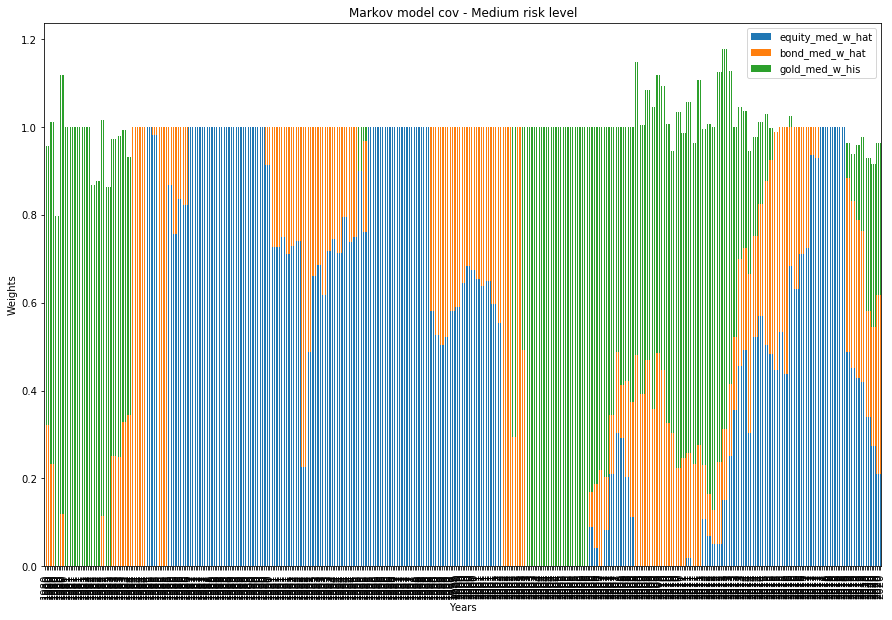

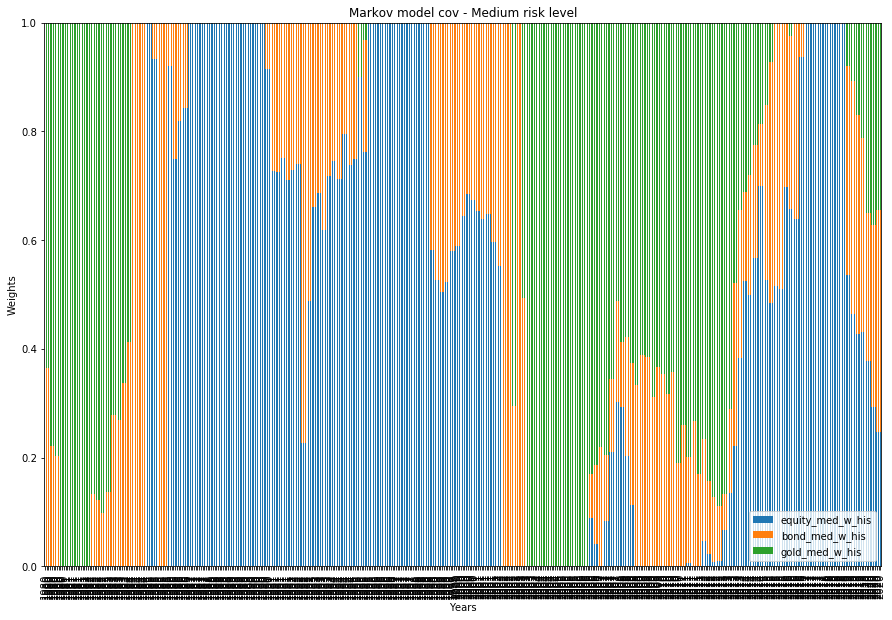

In [91]:
returns.plot(
    x="year_x", y=['equity_med_w_hat', 'bond_med_w_hat', 'gold_med_w_his'],kind='bar', stacked=True, figsize=(15,10))
plt.title("Markov model cov - Medium risk level")
plt.xlabel("Years")
plt.ylabel("Weights")

returns.plot(
    x="year_x", y=['equity_med_w_his', 'bond_med_w_his', 'gold_med_w_his'],kind='bar', stacked=True, figsize=(15,10))
plt.title("Markov model cov - Medium risk level")
plt.xlabel("Years")
plt.ylabel("Weights")

Text(0.5, 1.0, 'Markov model cov - High risk level')

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Weights')

Text(0.5, 1.0, 'Markov model cov - High risk level')

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Weights')

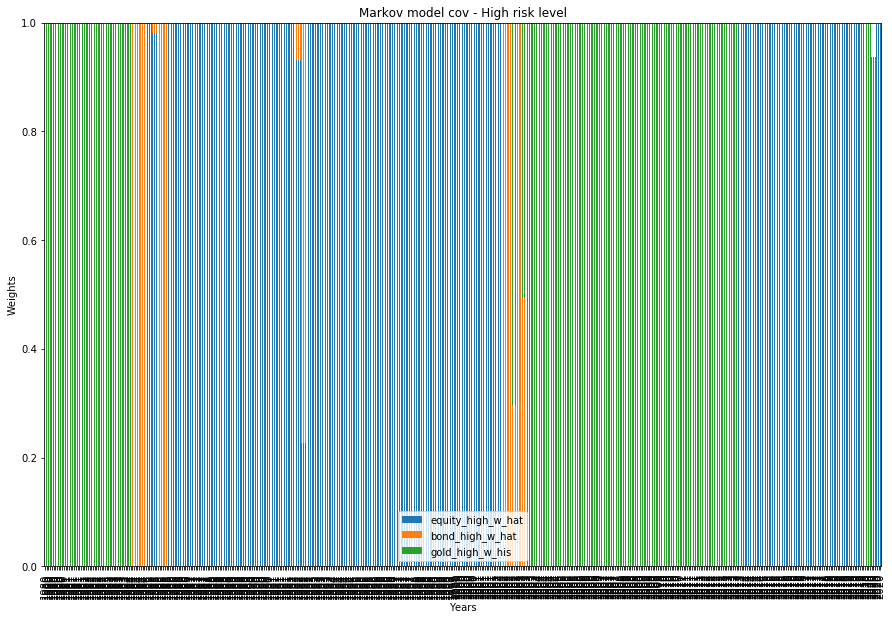

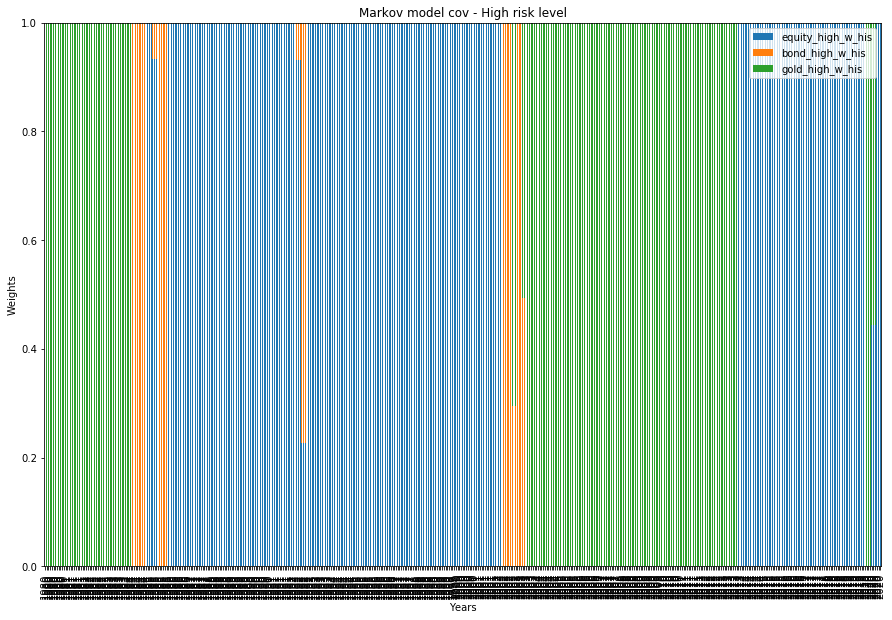

In [92]:
returns.plot(
    x="year_x", y=['equity_high_w_hat', 'bond_high_w_hat', 'gold_high_w_his'],kind='bar', stacked=True, figsize=(15,10))
plt.title("Markov model cov - High risk level")
plt.xlabel("Years")
plt.ylabel("Weights")

returns.plot(
    x="year_x", y=['equity_high_w_his', 'bond_high_w_his', 'gold_high_w_his'],kind='bar', stacked=True, figsize=(15,10))
plt.title("Markov model cov - High risk level")
plt.xlabel("Years")
plt.ylabel("Weights")

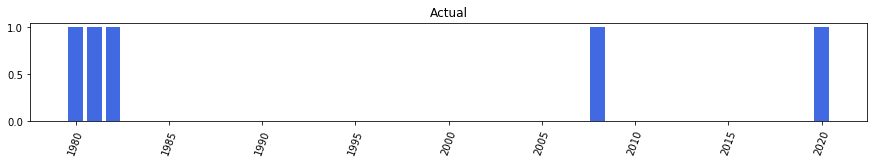

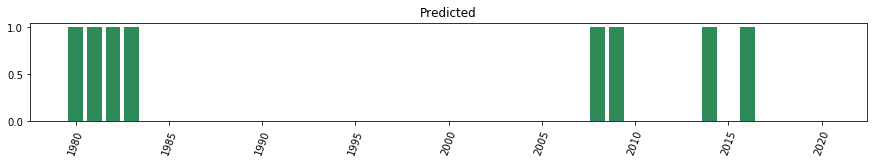

In [93]:
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.month.apply(
   lambda v: 'Q1' if v <= 3 else 'Q2' if v <= 6 else 'Q3' if v <= 9 else 'Q4')
df['year_quarter'] = df.year.astype(str) + '-' + df.quarter.astype(str)

plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
plt.bar(df['year'],df['y_test'],color='royalblue')
plt.title('Actual')
plt.xticks(rotation=70)

plt.figure(figsize=(15,4))
plt.subplot(2,1,2)
plt.bar(df['year'],df['y_predicted'],color='seagreen')
plt.title('Predicted')
plt.xticks(rotation=70)

plt.show();